In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/qos-metrics/device_metrics.csv
/kaggle/input/cicddos2019/Syn-training.parquet
/kaggle/input/cicddos2019/UDPLag-testing.parquet
/kaggle/input/cicddos2019/NetBIOS-testing.parquet
/kaggle/input/cicddos2019/Portmap-training.parquet
/kaggle/input/cicddos2019/Syn-testing.parquet
/kaggle/input/cicddos2019/MSSQL-testing.parquet
/kaggle/input/cicddos2019/SNMP-testing.parquet
/kaggle/input/cicddos2019/UDPLag-training.parquet
/kaggle/input/cicddos2019/NTP-testing.parquet
/kaggle/input/cicddos2019/LDAP-testing.parquet
/kaggle/input/cicddos2019/UDP-training.parquet
/kaggle/input/cicddos2019/NetBIOS-training.parquet
/kaggle/input/cicddos2019/DNS-testing.parquet
/kaggle/input/cicddos2019/UDP-testing.parquet
/kaggle/input/cicddos2019/LDAP-training.parquet
/kaggle/input/cicddos2019/TFTP-testing.parquet
/kaggle/input/cicddos2019/MSSQL-training.parquet
/kaggle/input/best-rf-model/scikitlearn/default/1/best_random_forest_model.joblib


In [4]:
import re
import time
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

import os
from tqdm import tqdm
import matplotlib.figure as fig
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier


import pickle

import warnings
warnings.filterwarnings('ignore')

# Data paths

In [5]:
dataset_paths = {
    "dns_testing": "/kaggle/input/cicddos2019/DNS-testing.parquet",
    "ldap_testing": "/kaggle/input/cicddos2019/LDAP-testing.parquet",
    "ldap_training": "/kaggle/input/cicddos2019/LDAP-training.parquet",
    "mssql_testing": "/kaggle/input/cicddos2019/MSSQL-testing.parquet",
    "mssql_training": "/kaggle/input/cicddos2019/MSSQL-training.parquet",
    "ntp_testing": "/kaggle/input/cicddos2019/NTP-testing.parquet",
    "netbios_training": "/kaggle/input/cicddos2019/NetBIOS-training.parquet",
    "netbios_testing": "/kaggle/input/cicddos2019/NetBIOS-testing.parquet",
    "portmap_training": "/kaggle/input/cicddos2019/Portmap-training.parquet",
    "snmp_testing": "/kaggle/input/cicddos2019/SNMP-testing.parquet",
    "syn_testing": "/kaggle/input/cicddos2019/Syn-testing.parquet",
    "syn_training": "/kaggle/input/cicddos2019/Syn-training.parquet",
    "tftp_testing": "/kaggle/input/cicddos2019/TFTP-testing.parquet",
    "udp_testing": "/kaggle/input/cicddos2019/UDP-testing.parquet",
    "udp_training": "/kaggle/input/cicddos2019/UDP-training.parquet",
    "udplag_testing": "/kaggle/input/cicddos2019/UDPLag-testing.parquet",
    "udplag_training": "/kaggle/input/cicddos2019/UDPLag-training.parquet"
}

# Data preparation

In [6]:
# Load datasets into DataFrames
dataframes = {name: pd.read_parquet(path) for name, path in dataset_paths.items()}

# List of all DataFrames with their names for better tracking
dataframes_list = list(dataframes.items())

**Check if each dataset has the same columns or feature names**

In [7]:
# Reference columns from the first DataFrame
reference_name, reference_df = dataframes_list[0]
reference_columns = reference_df.columns

# Check each DataFrame against the reference
for name, df in dataframes_list:
    print(f"Checking DataFrame: {name}")
    if df.columns.equals(reference_columns):
        print("Columns match the reference.")
    else:
        print("Columns do not match the reference.")
        print(f"Different Columns: {list(df.columns)}")

# Set to store unique dataset identifiers
unique_datasets = {name.split('_')[0] for name, _ in dataframes_list}
print(f"Number of unique datasets: {len(unique_datasets)}")

Checking DataFrame: dns_testing
Columns match the reference.
Checking DataFrame: ldap_testing
Columns match the reference.
Checking DataFrame: ldap_training
Columns match the reference.
Checking DataFrame: mssql_testing
Columns match the reference.
Checking DataFrame: mssql_training
Columns match the reference.
Checking DataFrame: ntp_testing
Columns match the reference.
Checking DataFrame: netbios_training
Columns match the reference.
Checking DataFrame: netbios_testing
Columns match the reference.
Checking DataFrame: portmap_training
Columns match the reference.
Checking DataFrame: snmp_testing
Columns match the reference.
Checking DataFrame: syn_testing
Columns match the reference.
Checking DataFrame: syn_training
Columns match the reference.
Checking DataFrame: tftp_testing
Columns match the reference.
Checking DataFrame: udp_testing
Columns match the reference.
Checking DataFrame: udp_training
Columns match the reference.
Checking DataFrame: udplag_testing
Columns match the refere

**Check the unique target classes in each dataset**

In [8]:
# Print unique values for the "Label" feature
for name, df in dataframes_list:
    if "Label" in df.columns:
        unique_labels = df["Label"].unique()
        print(f"Unique values for 'Label' in '{name}' DataFrame:")
        print(unique_labels, "")

Unique values for 'Label' in 'dns_testing' DataFrame:
['DrDoS_DNS', 'Benign']
Categories (2, object): ['Benign', 'DrDoS_DNS'] 
Unique values for 'Label' in 'ldap_testing' DataFrame:
['DrDoS_LDAP', 'Benign']
Categories (2, object): ['Benign', 'DrDoS_LDAP'] 
Unique values for 'Label' in 'ldap_training' DataFrame:
['NetBIOS', 'LDAP', 'Benign']
Categories (3, object): ['Benign', 'LDAP', 'NetBIOS'] 
Unique values for 'Label' in 'mssql_testing' DataFrame:
['DrDoS_MSSQL', 'Benign']
Categories (2, object): ['Benign', 'DrDoS_MSSQL'] 
Unique values for 'Label' in 'mssql_training' DataFrame:
['MSSQL', 'LDAP', 'Benign']
Categories (3, object): ['Benign', 'LDAP', 'MSSQL'] 
Unique values for 'Label' in 'ntp_testing' DataFrame:
['DrDoS_NTP', 'Benign']
Categories (2, object): ['Benign', 'DrDoS_NTP'] 
Unique values for 'Label' in 'netbios_training' DataFrame:
['NetBIOS', 'Benign']
Categories (2, object): ['Benign', 'NetBIOS'] 
Unique values for 'Label' in 'netbios_testing' DataFrame:
['DrDoS_NetBIOS', 

**Combine the datasets (Training + Testing)**

I noticed that many of the datasets doesnt have a testing pair, so i need to combine them and split each of them to get an even proportion for the training and testing pair.

In [9]:
# Combine training datasets
combined_datasets = {}
for name, df in dataframes_list:
    base_name = name.split('_')[0]
    if base_name not in combined_datasets:
        combined_datasets[base_name] = df
    else:
        combined_datasets[base_name] = pd.concat([combined_datasets[base_name], df], ignore_index=True)

# Print the final combined datasets
for key in combined_datasets.keys():
    print(f"Combined DataFrame: {key}")

Combined DataFrame: dns
Combined DataFrame: ldap
Combined DataFrame: mssql
Combined DataFrame: ntp
Combined DataFrame: netbios
Combined DataFrame: portmap
Combined DataFrame: snmp
Combined DataFrame: syn
Combined DataFrame: tftp
Combined DataFrame: udp
Combined DataFrame: udplag


**Convert the combined dict to dataframe**

In [10]:
df = pd.concat(combined_datasets.values(), ignore_index=True)
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,48,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
1,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
2,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
3,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,...,1480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS
4,17,1,2,0,2896.0,0.0,1448.0,1448.0,1448.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DrDoS_DNS


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431371 entries, 0 to 431370
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  431371 non-null  int8   
 1   Flow Duration             431371 non-null  int32  
 2   Total Fwd Packets         431371 non-null  int32  
 3   Total Backward Packets    431371 non-null  int16  
 4   Fwd Packets Length Total  431371 non-null  float32
 5   Bwd Packets Length Total  431371 non-null  float32
 6   Fwd Packet Length Max     431371 non-null  float32
 7   Fwd Packet Length Min     431371 non-null  float32
 8   Fwd Packet Length Mean    431371 non-null  float32
 9   Fwd Packet Length Std     431371 non-null  float32
 10  Bwd Packet Length Max     431371 non-null  float32
 11  Bwd Packet Length Min     431371 non-null  float32
 12  Bwd Packet Length Mean    431371 non-null  float32
 13  Bwd Packet Length Std     431371 non-null  f

**Remove duplicates**

In [12]:
df.duplicated().sum()

5295

In [13]:
df.drop_duplicates(inplace=True)

**Defining X and y**

In [14]:
X = df.drop(columns=["Label"])
y = df["Label"] 

In [15]:
X = X.astype("float64")

**Encode target feature**

In [16]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_encoded = label_encoder.fit_transform(y)  # y is assumed to be a pandas Series

# Convert y into a DataFrame (if it's not already)
y = pd.DataFrame(y, columns=['Label'])  
y['Label'] = y_encoded  # Assign the encoded labels correctly

# Print the mapping of original labels to encoded values
label_mapping = pd.DataFrame({
    'Original Label': label_encoder.classes_,
    'Encoded Value': range(len(label_encoder.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          Benign              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7       DrDoS_UDP              7
8            LDAP              8
9           MSSQL              9
10        NetBIOS             10
11        Portmap             11
12            Syn             12
13           TFTP             13
14            UDP             14
15        UDP-lag             15
16         UDPLag             16
17        WebDDoS             17


**Split the dataset into training and testing set**

In [17]:
# 1) Train + Temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,          # 20% test + 10% val
    stratify=y,
    random_state=42,
    shuffle=True
)

# 2) Validation + Test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,          # 20% test, 10% val
    stratify=y_temp,
    random_state=42,
    shuffle=True
)


In [18]:
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (298253, 77) (298253, 1)
Testing set shape: (85216, 77) (85216, 1)


# Model training

Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

Training Random Forest......


Training Models:  20%|██        | 1/5 [05:11<20:46, 311.59s/it]

Training KNN......


Training Models:  40%|████      | 2/5 [10:29<15:46, 315.58s/it]

Training MLP Classifier......


Training Models:  60%|██████    | 3/5 [18:31<13:02, 391.29s/it]

Training XGBoost......


Training Models:  80%|████████  | 4/5 [23:04<05:44, 344.57s/it]

Training LGBMClassifier......
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14124
[LightGBM] [Info] Number of data points in the train set: 298253, number of used features: 65
[LightGBM] [Info] Start training from score -1.503858
[LightGBM] [Info] Start training from score -4.754815
[LightGBM] [Info] Start training from score -5.689974
[LightGBM] [Info] Start training from score -4.228226
[LightGBM] [Info] Start training from score -1.255785
[LightGBM] [Info] Start training from score -6.567826
[LightGBM] [Info] Start training from score -5.055036
[LightGBM] [Info] Start training from score -3.710890
[LightGBM] [Info] Start training from score -5.421068
[LightGBM] [Info] Start training from score -3.92

Training Models: 100%|██████████| 5/5 [26:26<00:00, 317.28s/it]


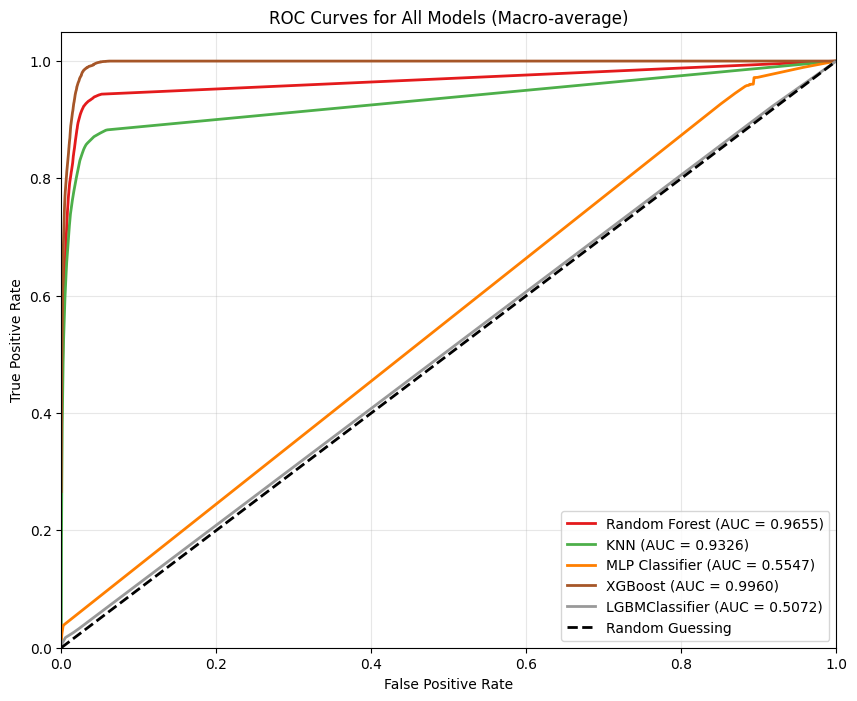

Testing Scores between different models:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score
0,Random Forest,0.927101,0.926597,0.927101,0.926745,0.965549,0.928001
1,KNN,0.905790,0.898712,0.905790,0.901172,0.932624,0.902730
2,MLP Classifier,0.375854,0.495286,0.375854,0.276644,0.554713,0.399583
3,XGBoost,0.940221,0.938750,0.940221,0.937862,0.995965,0.939934
4,LGBMClassifier,0.235619,0.070438,0.235619,0.097460,0.507216,0.531432


In [19]:
# Train and evaluate models
def train_model(X_train, X_test, y_train, y_test):
    # Initialize models
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=10),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
        "XGBoost": XGBClassifier(),
        "LGBMClassifier": LGBMClassifier(),
    }

    scores_list = []

    # Initialize plot for ROC curves
    plt.figure(figsize=(10, 8))
    
    # Store colors for consistent plotting
    colors = plt.cm.Set1(np.linspace(0, 1, len(classifiers)))

    # Train and evaluate models with progress bar
    for idx, (name, model) in enumerate(tqdm(classifiers.items(), desc=f"Training Models")):
        print(f"Training {name}......")
        
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate predictions for multiclass
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Calculate ROC AUC (One-vs-Rest)
        y_proba = model.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")

        cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

        # ROC curve (One-vs-Rest macro-average)
        # For multiclass, we can plot macro-average ROC curve
        from sklearn.preprocessing import label_binarize
        
        # Binarize the labels for ROC calculation
        y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
        n_classes = y_test_bin.shape[1]
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute macro-average ROC curve and ROC area
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])  # Changed from scipy.interp to np.interp
        
        mean_tpr /= n_classes
        
        fpr_macro = all_fpr
        tpr_macro = mean_tpr
        roc_auc_macro = auc(fpr_macro, tpr_macro)
        
        # Plot macro-average ROC curve
        plt.plot(fpr_macro, tpr_macro, color=colors[idx], 
                 lw=2, label=f'{name} (AUC = {roc_auc_macro:.4f})')

        # Append scores to the list
        scores_list.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc_macro,
            "CV Score": cv_score
        })

    # Finalize the ROC plot
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guessing")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models (Macro-average)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

    # Create and display the DataFrame of scores
    scores = pd.DataFrame(scores_list)
    return scores

# Run the function
scores = train_model(X_train, X_val, y_train, y_val)
print("Testing Scores between different models:")
display(scores.style.background_gradient(cmap='viridis'))

Starting CNN and LSTM training...
DEEP LEARNING MODELS FOR DDoS DETECTION

1. Preparing data for deep learning...
   Data shape: (298253, 1, 77)
   Number of classes: 18
   Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]

2. Training CNN Model...
TRAINING CNN MODEL
CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │           4,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 256)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,658 (346.32 KB)

 Trainable params: 88,658 (346.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.1705 - auc: 0.6237 - loss: 1887654.8750 - precision: 0.1205 - recall: 0.0682 - val_accuracy: 0.2848 - val_auc: 0.8831 - val_loss: 1.8743 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2825 - auc: 0.8814 - loss: 217.1361 - precision: 0.1864 - recall: 4.2100e-04 - val_accuracy: 0.2848 - val_auc: 0.8823 - val_loss: 1.8663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2854 - auc: 0.8821 - loss: 95.4545 - precision: 0.1764 - recall: 6.8269e-05 - val_accuracy: 0.2848 - val_auc: 0.8823 - val_loss: 1.8656 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.2854 - auc: 0.8822 - loss: 10.6719 - precision: 0.2735 - recall: 3.0496e-05 - val_accuracy: 0.2848 - val_auc: 0.8823 - val_loss: 1.8655 - val_precision: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 77, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 77, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 77, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 18)                  │           1,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,714 (522.32 KB)

 Trainable params: 133,714 (522.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 56s 11ms/step - accuracy: 0.8521 - auc: 0.9862 - loss: 0.4965 - precision: 0.9374 - recall: 0.8019 - val_accuracy: 0.8905 - val_auc: 0.9915 - val_loss: 0.3590 - val_precision: 0.9449 - val_recall: 0.8686
Epoch 2/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9147 - auc: 0.9963 - loss: 0.2582 - precision: 0.9649 - recall: 0.8876 - val_accuracy: 0.9212 - val_auc: 0.9976 - val_loss: 0.2106 - val_precision: 0.9600 - val_recall: 0.8997
Epoch 3/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9192 - auc: 0.9969 - loss: 0.2274 - precision: 0.9649 - recall: 0.8918 - val_accuracy: 0.9196 - val_auc: 0.9975 - val_loss: 0.2130 - val_precision: 0.9689 - val_recall: 0.8944
Epoch 4/30
4661/4661 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9204 - auc: 0.9974 - loss: 0.2149 - precision: 0.9645 - recall: 0.8948 - val_accuracy: 0.9248 - val_auc: 0.9979 - val_loss: 0.1859 - val_precision: 0.9578 - val_recall: 0.9074
Epoch 5/30
4661/

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,CNN,0.284836,0.081131,0.284836,0.126291,0.500000
1,LSTM,0.933180,0.924638,0.933180,0.926434,0.994503



VISUALIZATIONS

• Plotting training history...


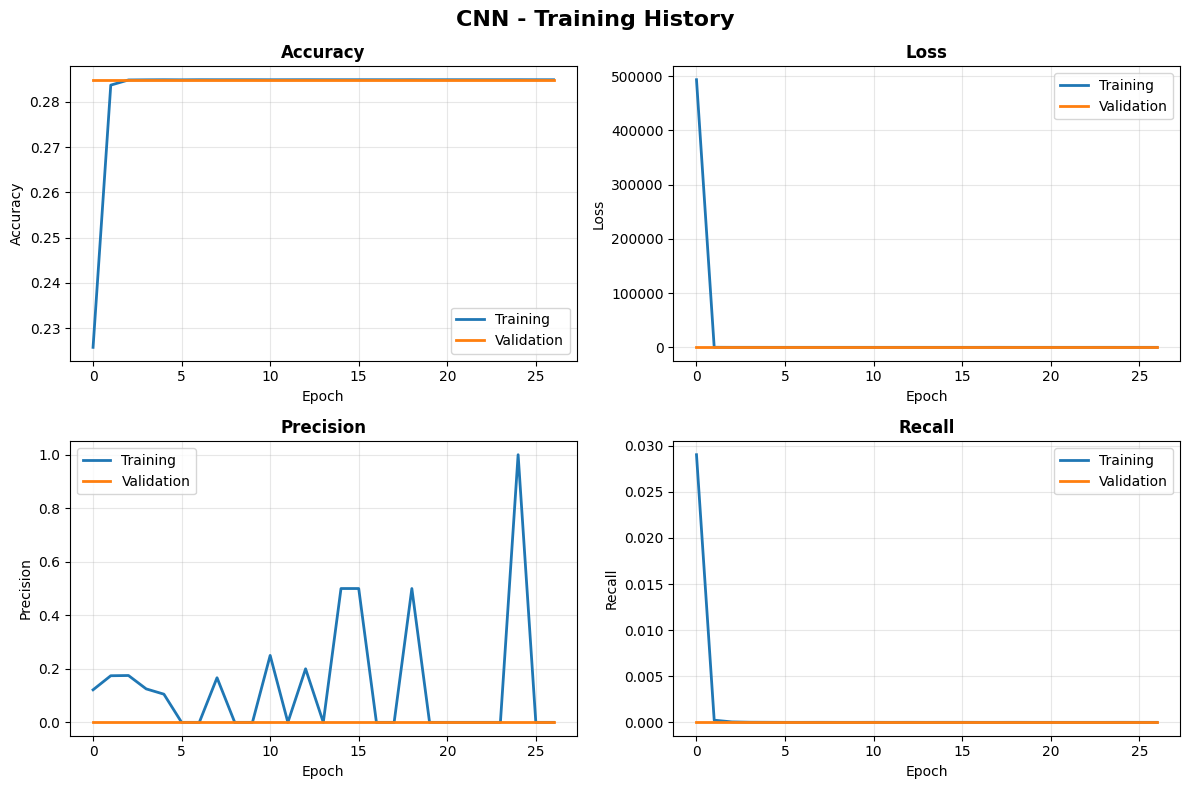

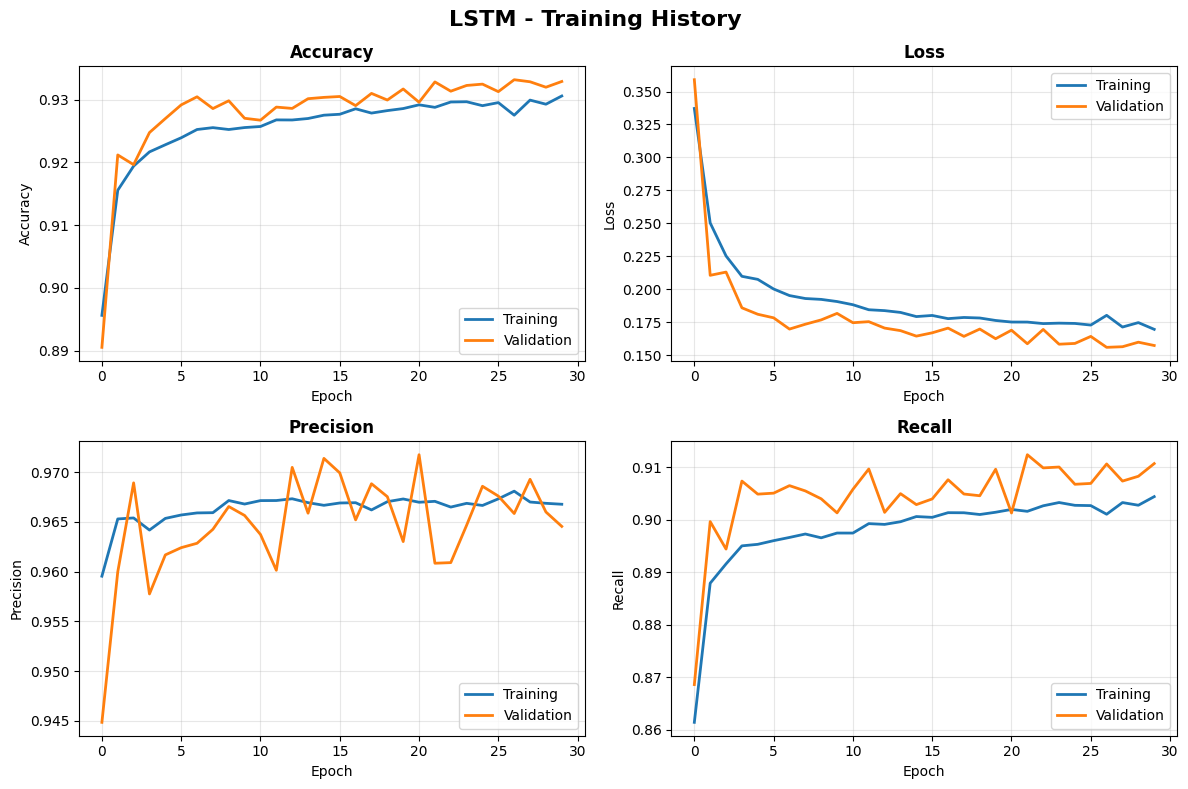


• Plotting confusion matrices...


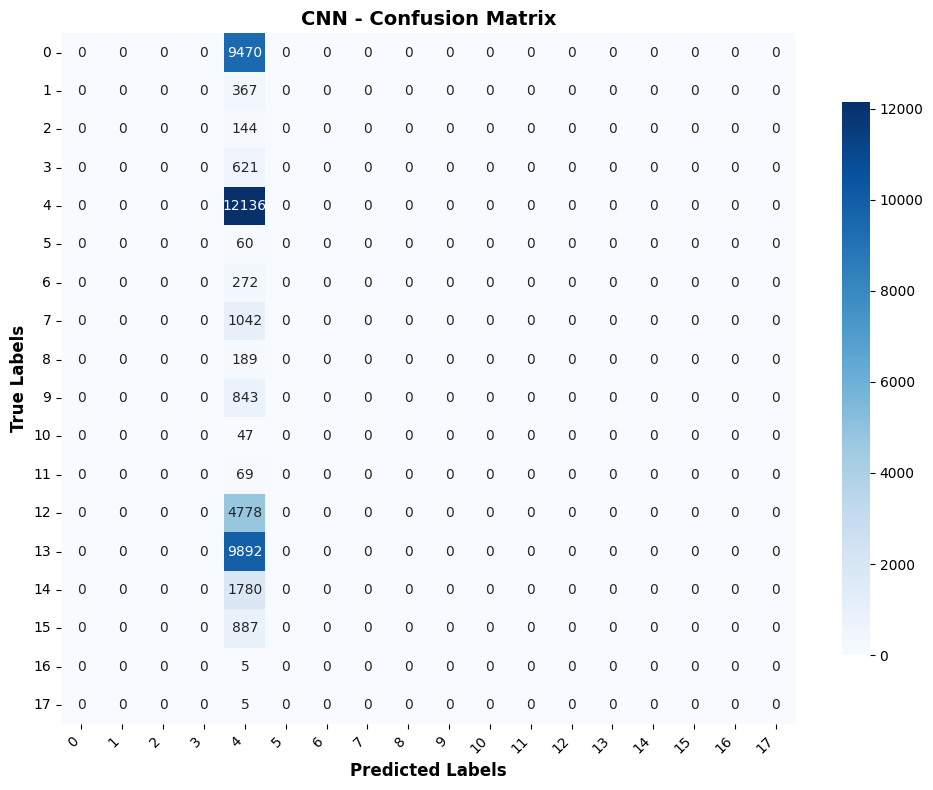

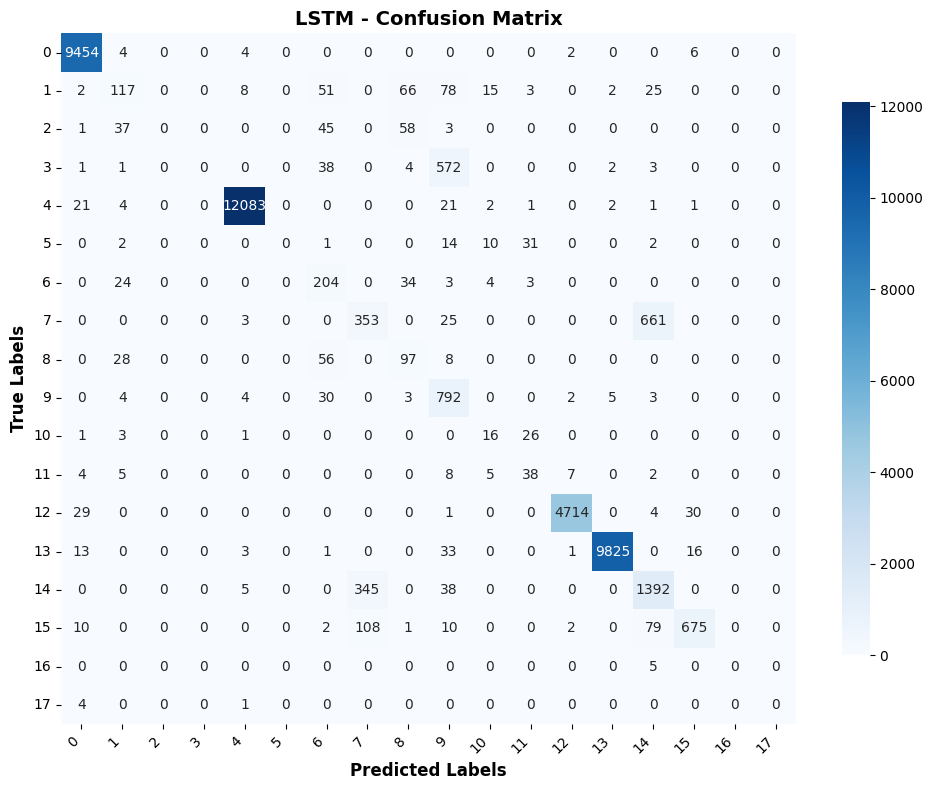


• Plotting ROC curves...


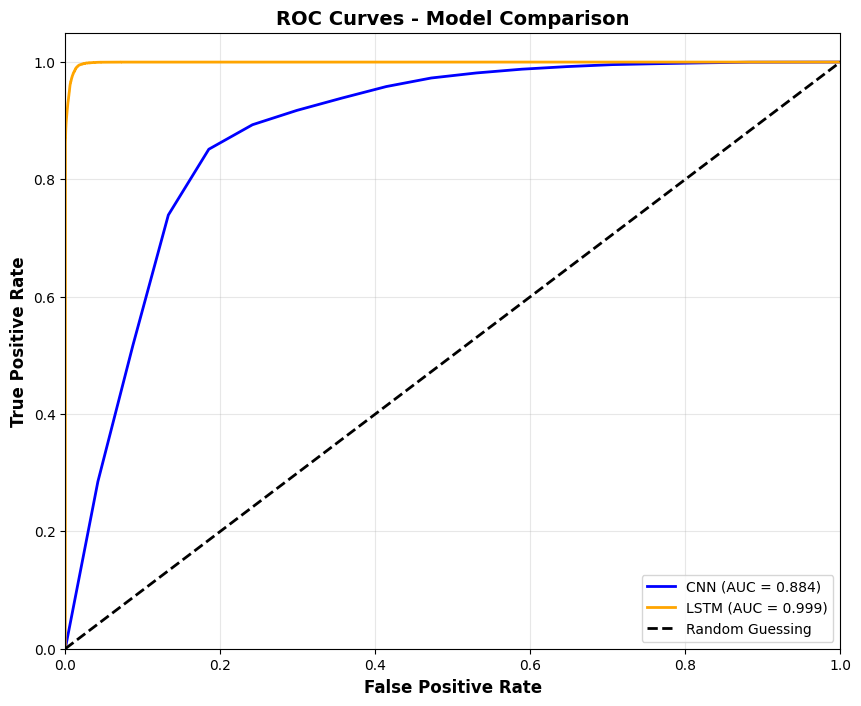


• Plotting metrics comparison...


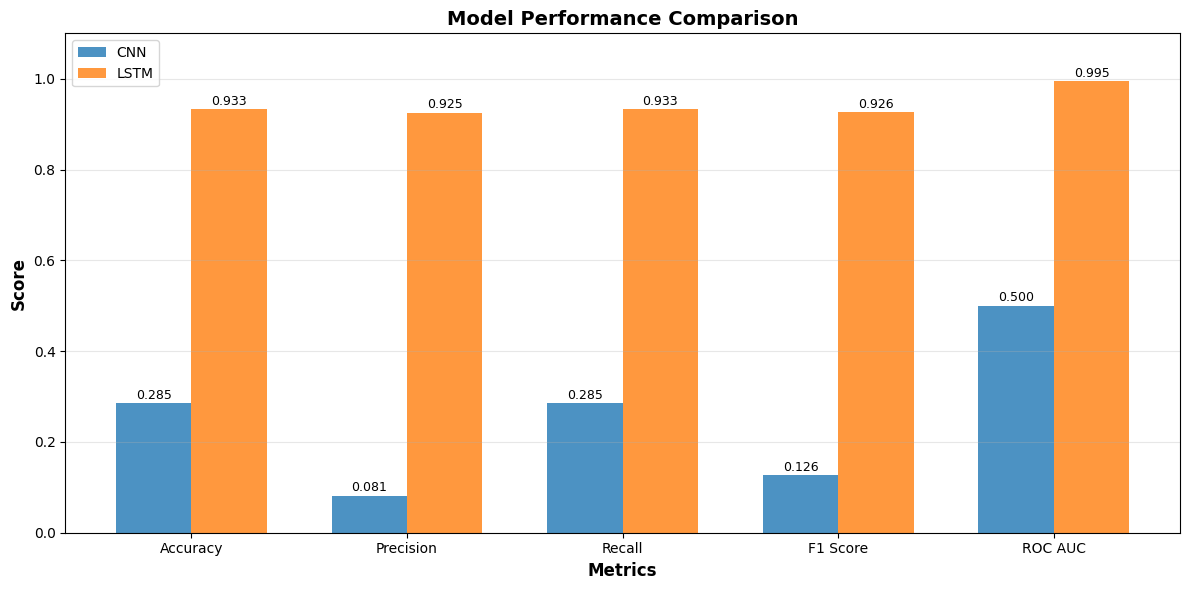


DETAILED CLASSIFICATION REPORTS

CNN Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9470
           1       0.00      0.00      0.00       367
           2       0.00      0.00      0.00       144
           3       0.00      0.00      0.00       621
           4       0.28      1.00      0.44     12136
           5       0.00      0.00      0.00        60
           6       0.00      0.00      0.00       272
           7       0.00      0.00      0.00      1042
           8       0.00      0.00      0.00       189
           9       0.00      0.00      0.00       843
          10       0.00      0.00      0.00        47
          11       0.00      0.00      0.00        69
          12       0.00      0.00      0.00      4778
          13       0.00      0.00      0.00      9892
          14       0.00      0.00      0.00      1780
          15       0.00

In [42]:
# COMPLETE CNN & LSTM IMPLEMENTATION FOR DDoS DETECTION
# =====================================================

# Import all necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout, 
                                    LSTM, Reshape, GlobalAveragePooling1D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, auc, 
                            confusion_matrix, classification_report)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =====================================================
# 1. DATA PREPARATION FUNCTIONS
# =====================================================

def prepare_data_for_dl(X_train, X_test, y_train, y_test):
    """
    Prepare data for deep learning models
    """
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    # Get number of classes
    n_classes = len(np.unique(y_train_encoded))
    
    # Convert to one-hot encoding
    y_train_onehot = to_categorical(y_train_encoded, num_classes=n_classes)
    y_test_onehot = to_categorical(y_test_encoded, num_classes=n_classes)
    
    # Reshape for CNN/LSTM: (samples, timesteps, features)
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train_reshaped, X_test_reshaped, y_train_onehot, y_test_onehot, n_classes, le

# =====================================================
# 2. MODEL BUILDING FUNCTIONS
# =====================================================

def build_cnn_model(input_shape, n_classes):
    """
    Build CNN model for DDoS detection
    """
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', 
               input_shape=input_shape, padding='same'),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=1, activation='relu', padding='same'),
        Dropout(0.3),
        Conv1D(filters=256, kernel_size=1, activation='relu', padding='same'),
        Dropout(0.3),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

def build_lstm_model(input_shape, n_classes):
    """
    Build LSTM model for DDoS detection
    """
    model = Sequential([
        Reshape((input_shape[0] * input_shape[1], 1), input_shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

# =====================================================
# 3. MODEL TRAINING FUNCTIONS
# =====================================================

def train_cnn_model(X_train, X_test, y_train, y_test, n_classes):
    """
    Train and evaluate CNN model
    """
    print("=" * 50)
    print("TRAINING CNN MODEL")
    print("=" * 50)
    
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_cnn_model(input_shape, n_classes)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    print("CNN Model Summary:")
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

def train_lstm_model(X_train, X_test, y_train, y_test, n_classes):
    """
    Train and evaluate LSTM model
    """
    print("\n" + "=" * 50)
    print("TRAINING LSTM MODEL")
    print("=" * 50)
    
    # Build model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, n_classes)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    
    print("LSTM Model Summary:")
    model.summary()
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

# =====================================================
# 4. EVALUATION FUNCTIONS
# =====================================================

def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    """
    Evaluate model and return comprehensive metrics
    """
    # Get predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Classification report - convert class names to strings
    class_names = [str(cls) for cls in label_encoder.classes_]
    report = classification_report(y_true, y_pred, 
                                   target_names=class_names,
                                   zero_division=0)
    
    return {
        'model_name': model_name,
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'class_names': class_names
    }

def compare_models(cnn_results, lstm_results):
    """
    Compare CNN and LSTM model performance
    """
    comparison_data = []
    
    for results in [cnn_results, lstm_results]:
        comparison_data.append({
            'Model': results['model_name'],
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1 Score': results['f1_score'],
            'ROC AUC': results['roc_auc']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + "=" * 70)
    print("MODEL PERFORMANCE COMPARISON")
    print("=" * 70)
    
    display(comparison_df.style.background_gradient(cmap='viridis', 
                                                   subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']))
    
    return comparison_df

# =====================================================
# 5. VISUALIZATION FUNCTIONS
# =====================================================

def plot_training_history(history, model_name):
    """
    Plot training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Precision', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Recall', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(results, title):
    """
    Plot confusion matrix
    """
    cm = results['confusion_matrix']
    class_names = results['class_names']
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': 0.8})
    plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    plt.ylabel('True Labels', fontsize=12, fontweight='bold')
    plt.title(f'{title} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results_list):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    for idx, results in enumerate(results_list):
        model_name = results['model_name']
        y_test = results['y_true']
        y_pred_proba = results['y_pred_proba']
        
        # Binarize labels for ROC calculation
        from sklearn.preprocessing import label_binarize
        n_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        
        # Compute micro-average ROC curve and ROC area
        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        # Plot ROC curve
        plt.plot(fpr_micro, tpr_micro, color=colors[idx % len(colors)], 
                 lw=2, label=f'{model_name} (AUC = {roc_auc_micro:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_metrics_comparison(comparison_df):
    """
    Plot metrics comparison between models
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        model_scores = [row[metric] for metric in metrics]
        ax.bar(x + (i * width) - (width/2), model_scores, width, 
               label=row['Model'], alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    # Add value labels
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        model_scores = [row[metric] for metric in metrics]
        for j, v in enumerate(model_scores):
            ax.text(j + (i * width) - (width/2), v + 0.01, f'{v:.3f}', 
                   ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# =====================================================
# 6. MAIN EXECUTION FUNCTION
# =====================================================

def train_and_evaluate_cnn_lstm(X_train, X_val, y_train, y_val):
    """
    Main function to train and evaluate CNN and LSTM models
    """
    print("=" * 70)
    print("DEEP LEARNING MODELS FOR DDoS DETECTION")
    print("=" * 70)
    
    # 1. Prepare data
    print("\n1. Preparing data for deep learning...")
    X_train_dl, X_val_dl, y_train_dl, y_val_dl, n_classes, label_encoder = prepare_data_for_dl(
        X_train, X_val, y_train, y_val
    )
    
    print(f"   Data shape: {X_train_dl.shape}")
    print(f"   Number of classes: {n_classes}")
    print(f"   Classes: {label_encoder.classes_}")
    
    # 2. Train CNN
    print("\n2. Training CNN Model...")
    cnn_model, cnn_history = train_cnn_model(
        X_train_dl, X_val_dl, y_train_dl, y_val_dl, n_classes
    )
    
    # 3. Train LSTM
    print("\n3. Training LSTM Model...")
    lstm_model, lstm_history = train_lstm_model(
        X_train_dl, X_val_dl, y_train_dl, y_val_dl, n_classes
    )
    
    # 4. Evaluate models
    print("\n4. Evaluating models...")
    cnn_results = evaluate_model(cnn_model, X_val_dl, y_val_dl, "CNN", label_encoder)
    lstm_results = evaluate_model(lstm_model, X_val_dl, y_val_dl, "LSTM", label_encoder)
    
    # 5. Compare models
    comparison_df = compare_models(cnn_results, lstm_results)
    
    # 6. Visualizations
    print("\n" + "=" * 70)
    print("VISUALIZATIONS")
    print("=" * 70)
    
    # Plot training history
    print("\n• Plotting training history...")
    plot_training_history(cnn_history, "CNN")
    plot_training_history(lstm_history, "LSTM")
    
    # Plot confusion matrices
    print("\n• Plotting confusion matrices...")
    plot_confusion_matrix(cnn_results, "CNN")
    plot_confusion_matrix(lstm_results, "LSTM")
    
    # Plot ROC curves
    print("\n• Plotting ROC curves...")
    plot_roc_curves([cnn_results, lstm_results])
    
    # Plot metrics comparison
    print("\n• Plotting metrics comparison...")
    plot_metrics_comparison(comparison_df)
    
    # 7. Print detailed reports
    print("\n" + "=" * 70)
    print("DETAILED CLASSIFICATION REPORTS")
    print("=" * 70)
    
    print("\nCNN Classification Report:")
    print("-" * 50)
    print(cnn_results['classification_report'])
    
    print("\nLSTM Classification Report:")
    print("-" * 50)
    print(lstm_results['classification_report'])
    
    # 8. Return all results
    return {
        'cnn_model': cnn_model,
        'lstm_model': lstm_model,
        'cnn_history': cnn_history,
        'lstm_history': lstm_history,
        'cnn_results': cnn_results,
        'lstm_results': lstm_results,
        'comparison_df': comparison_df,
        'label_encoder': label_encoder
    }

# =====================================================
# 7. EXECUTE THE TRAINING
# =====================================================

# Run the complete training and evaluation
print("Starting CNN and LSTM training...")
results = train_and_evaluate_cnn_lstm(X_train, X_val, y_train, y_val)

print("\n" + "=" * 70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 70)

**XGBoost dominates with a near-perfect 99.6% ROC AUC, achieving 94.02% accuracy and a robust 0.938 F1 score, making it the undisputed champion for DDoS detection.**

## XGBosst Model Hyper-params fine tuning

In [21]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

def tune_xgboost_gpu_quick(X_train, y_train, X_val, y_val, n_iter=5):
    """
    Fast GPU-accelerated XGBoost tuning using a minimal parameter grid and optional subsampling.
    
    Parameters:
    -----------
    X_train, X_val : np.array or pd.DataFrame
        Training and validation features
    y_train, y_val : np.array or pd.Series
        Training and validation labels
    n_iter : int
        Number of random parameter trials
    
    Returns:
    --------
    dict : best model, best params, metrics, tuning time
    """
    start_time = time.time()
    
    # Flatten y if needed
    if len(np.shape(y_train)) > 1:
        y_train = np.ravel(y_train)
    if len(np.shape(y_val)) > 1:
        y_val = np.ravel(y_val)
    
    num_classes = len(np.unique(y_train))
    
    # Optional: subsample data for faster tuning
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    for idx, _ in sss.split(X_train, y_train):
        if hasattr(X_train, "iloc"):
            X_tune = X_train.iloc[idx]
        else:
            X_tune = X_train[idx]
        
        if hasattr(y_train, "iloc"):
            y_tune = y_train.iloc[idx]
        else:
            y_tune = y_train[idx]
    
    # GPU base parameters
    base_params = {
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'random_state': 42,
        'n_jobs': 1,  # important for GPU
        'verbosity': 0
    }
    
    # Minimal parameter grid for fast tuning
    param_grid = [
        {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 50},
        {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 50},
        {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 50},
        {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50},
        {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 50},
        {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 50}
    ][:n_iter]  # Limit to n_iter
    
    best_f1 = -1
    best_model = None
    best_params = None
    
    # Quick loop over parameter grid
    for params in param_grid:
        clf = xgb.XGBClassifier(**base_params, **params)
        clf.fit(X_tune, y_tune, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_model = clf
            best_params = params
    
    # Evaluate on full validation set
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)
    metrics = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_val, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_val, y_pred, average='weighted', zero_division=0),
        'roc_auc': roc_auc_score(y_val, y_pred_proba, multi_class="ovr", average="macro")
    }
    
    tuning_time = time.time() - start_time
    print(f"\n✅ FAST GPU tuning completed in {tuning_time:.1f}s")
    print(f"🎯 Best F1 Score: {metrics['f1']:.4f}")
    print(f"📊 Best Parameters: {best_params}")
    
    return {
        'model': best_model,
        'params': best_params,
        'metrics': metrics,
        'time': tuning_time
    }


In [22]:
# Run fast GPU tuning
results = tune_xgboost_gpu_quick(X_train, y_train, X_val, y_val, n_iter=5)

# Access results
best_model = results['model']
best_params = results['params']
metrics = results['metrics']
tuning_time = results['time']

print("Best model parameters:", best_params)
print("Validation metrics:", metrics)
print("Tuning completed in seconds:", tuning_time)



✅ FAST GPU tuning completed in 27.1s
🎯 Best F1 Score: 0.9353
📊 Best Parameters: {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 50}
Best model parameters: {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 50}
Validation metrics: {'accuracy': 0.9397986246391438, 'precision': 0.9376227782062965, 'recall': 0.9397986246391438, 'f1': 0.9352552303073753, 'roc_auc': 0.9943378577422816}
Tuning completed in seconds: 27.06251573562622


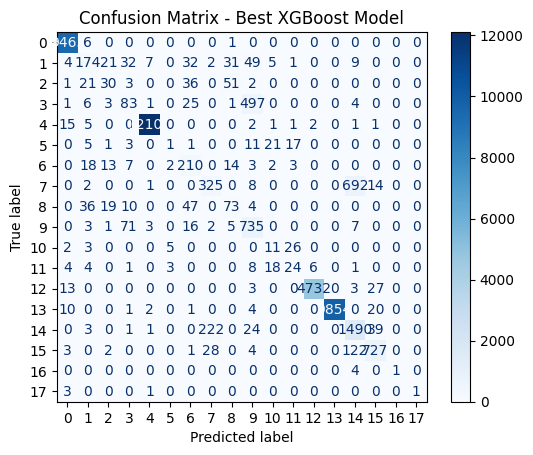

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_pred_val = best_model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)  # You can change the color map
plt.title("Confusion Matrix - Best XGBoost Model")
plt.show()


In [23]:
# Save the model
results['model'].save_model("best_xgb_model.json")

# Load later
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("best_xgb_model.json")
